# MORPHOLOGICAL OPERATIONS

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [54]:
image = cv2.imread('image4.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [34]:
ellipse_kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

In [35]:
kernel = np.ones((20, 20), np.uint8)

In [36]:
erosion = cv2.erode(image,ellipse_kernel_large, iterations=1)

In [37]:
dilation = cv2.dilate(image,ellipse_kernel_large, iterations=1)

In [38]:
opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, ellipse_kernel_large)

In [39]:
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, ellipse_kernel_large)

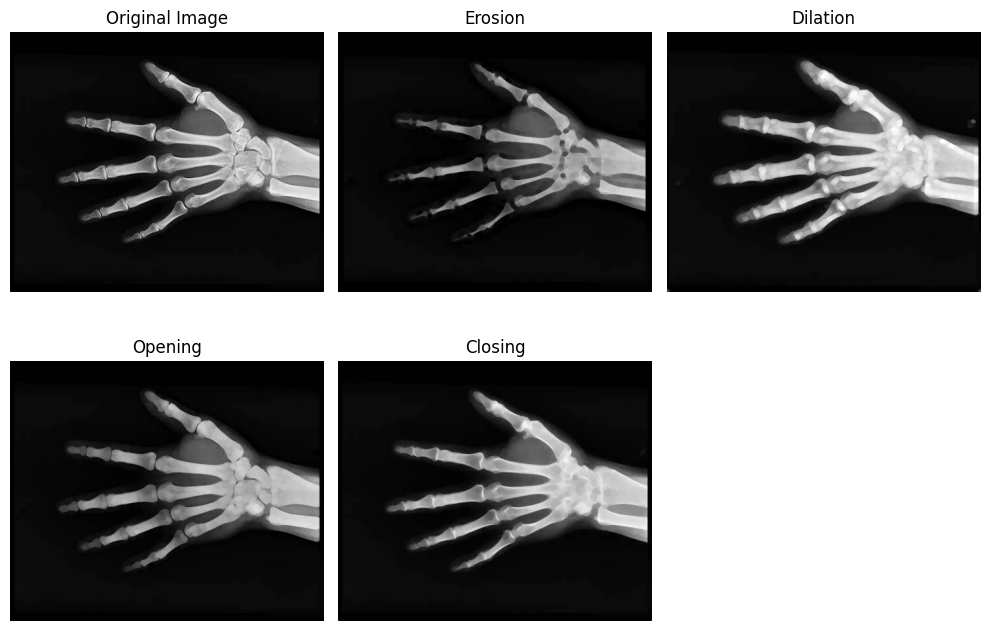

In [40]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Erosion')
plt.imshow(erosion, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Dilation')
plt.imshow(dilation, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Opening')
plt.imshow(opening, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Closing')
plt.imshow(closing, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# REGION GROWING

In [41]:
def region_growing(img, seed, threshold):
    output = np.zeros_like(img)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    to_visit = [seed]
    region_value = img[seed]
    while len(to_visit) > 0:
        x, y = to_visit.pop(0)
        if output[x, y] == 0:
            output[x, y] = 255  
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy
                if 0 <= nx < img.shape[0] and 0 <= ny < img.shape[1]:
                    if abs(int(img[nx, ny]) - int(region_value)) < threshold and output[nx, ny] == 0:
                        to_visit.append((nx, ny))
    
    return output

In [42]:
seed_point = (100, 100)
seed_point1 = (2, 2)
threshold = 225

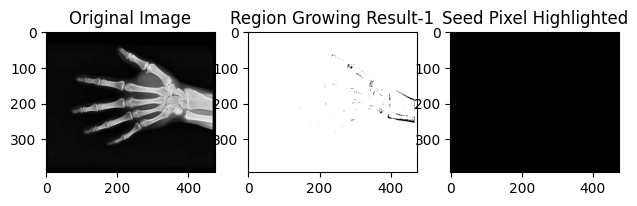

In [44]:
segmented_img = region_growing(gray, seed_point, threshold)
segmented_img1=region_growing(gray,seed_point1,threshold)
image = np.array(gray, dtype=np.uint8)
segmented_img = np.array(segmented_img, dtype=np.uint8)
segmented_img1=np.array(segmented_img1,dtype=np.uint8)
inverted_img = np.where(segmented_img == 255, segmented_img, 255 - image)
inverted_img= np.array(inverted_img, dtype=np.uint8)
highlighted_image = np.zeros_like(image)  
highlighted_image[seed_point] = 255
highlighted_image= np.array(highlighted_image, dtype=np.uint8)
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')  
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(segmented_img1, cmap='gray')
plt.title('Region Growing Result-1')
plt.subplot(1, 4, 3)
plt.imshow(highlighted_image, cmap='gray')
plt.title('Seed Pixel Highlighted')
plt.show()

# REGION SPLITING

In [13]:
def is_homogeneous(region, threshold):
    """Check if the region is homogeneous based on the intensity threshold."""
    min_val, max_val = np.min(region), np.max(region)
    return (max_val - min_val) <= threshold


In [14]:

def split_and_merge(image, threshold):
    """Segment the image by recursively splitting and merging regions."""
    
    def recursive_split(region):
        rows, cols = region.shape
        if rows <= 1 or cols <= 1:
            return np.zeros_like(region, dtype=np.uint8)
        
        if is_homogeneous(region, threshold):
            return np.ones_like(region, dtype=np.uint8)
        
        
        mid_row, mid_col = rows // 2, cols // 2
        
        
        top_left = region[:mid_row, :mid_col]
        top_right = region[:mid_row, mid_col:]
        bottom_left = region[mid_row:, :mid_col]
        bottom_right = region[mid_row:, mid_col:]
        
        
        segmented_quadrants = np.zeros_like(region, dtype=np.uint8)
        
       
        segmented_quadrants[:mid_row, :mid_col] = recursive_split(top_left)
        segmented_quadrants[:mid_row, mid_col:] = recursive_split(top_right)
        segmented_quadrants[mid_row:, :mid_col] = recursive_split(bottom_left)
        segmented_quadrants[mid_row:, mid_col:] = recursive_split(bottom_right)
        
        return segmented_quadrants

    def merge_regions(segmented):
        """Merge adjacent regions if they are similar."""
       
        return segmented

    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply the region splitting and merging algorithm
    segmented_image = recursive_split(image)
    segmented_image = merge_regions(segmented_image)
    
    return segmented_image

In [48]:
threshold = 31
threshold1=25
segmented_img = split_and_merge(gray, threshold)

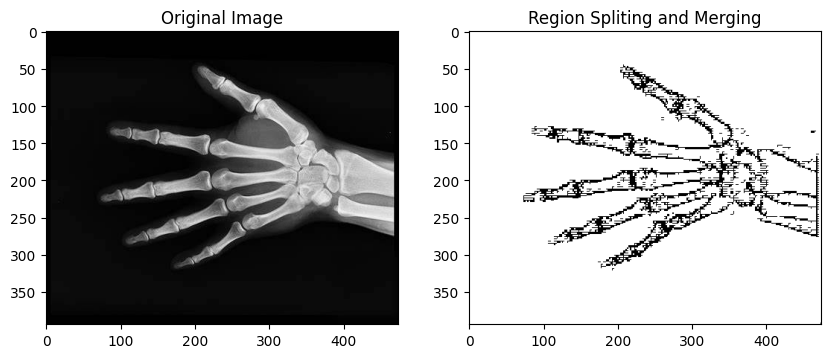

In [49]:
gray = np.array(gray, dtype=np.uint8)
segmented_img = np.array(segmented_img, dtype=np.uint8)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')  
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(segmented_img, cmap='gray')
plt.title('Region Spliting and Merging')
plt.show()

WATERSHED 

In [55]:
_, binary_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


In [56]:
kernel = np.ones((3,3), np.uint8)

In [57]:
opening = cv2.morphologyEx(binary_thresh, cv2.MORPH_OPEN, kernel, iterations=2)

In [58]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [59]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

In [60]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

In [61]:
_, markers = cv2.connectedComponents(sure_fg)


In [62]:
markers = markers + 1

In [63]:
markers[unknown == 255] = 0

In [64]:
markers = cv2.watershed(image, markers)

In [65]:
image[markers == -1] = [255, 0, 0]

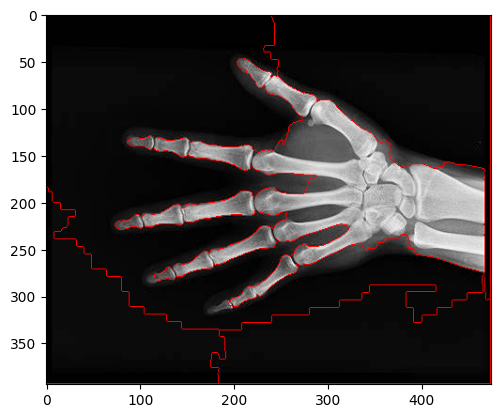

In [66]:
plt.imshow(image)

Convert Image to Grayscale: Many algorithms, including Watershed, work on grayscale images.

Thresholding: Convert the image to a binary image where the foreground objects and the background are separated.


Noise Removal with Morphological Operations: This helps in refining the foreground and background regions.


Marker Labelling: This is the most crucial step. We need markers to start flooding. Markers are pixels with unique labels for each connected component in the image.


Watershed Algorithm: Apply the algorithm on the markers to create segments.


Display the Result: Finally, draw the contours on the original image to visualize the segmented regions.

Grayscale Conversion: Convert the input image into a grayscale image because the watershed algorithm needs single-channel input.

Thresholding: We use Otsu’s thresholding to automatically choose a threshold value and convert the grayscale image into a binary image.

Morphological Operations: The opening operation (erosion followed by dilation) removes noise. Dilation is used to ensure that foreground objects are solid.

Sure Foreground and Background: Using the distance transform, we calculate how far each pixel is from the nearest zero pixel. This helps in identifying the foreground and background regions.

Markers: Each connected component in the image is assigned a unique label to help the watershed algorithm understand where to start flooding.

Watershed Algorithm: The algorithm floods from the markers and finds boundaries between objects.

Result: Boundaries of the segments are marked with red color, making it easy to visualize the segmented objects in the image.

The watershed algorithm is a powerful segmentation tool in image processing. It treats the grayscale image like a topographic surface where pixel values represent the elevation. The algorithm then "floods" this topography from various points (called markers), filling up basins and defining boundaries where waters from different basins meet.